In [1]:
import pykitti 
import numpy as np 
import matplotlib.pyplot as plt 
import utils.parse_tracklet_xml as parse_tracklet_xml
import cv2

from utils.visualize import load_dataset, load_tracklets_for_frames

In [2]:
basedir = 'data'

colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k',
}

In [3]:
frame = 10
date = '2011_09_26'
drive = '0001'
datadir = "data"
dataset = load_dataset(datadir, date, drive)


Drive: 2011_09_26_drive_0001_sync
Frame range: None


In [4]:
help(dataset)

Help on raw in module pykitti.raw object:

class raw(builtins.object)
 |  raw(base_path, date, drive, **kwargs)
 |  
 |  Load and parse raw data into a usable format.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, base_path, date, drive, **kwargs)
 |      Set the path and pre-load calibration data and timestamps.
 |  
 |  __len__(self)
 |      Return the number of frames loaded.
 |  
 |  get_cam0(self, idx)
 |      Read image file for cam0 (monochrome left) at the specified index.
 |  
 |  get_cam1(self, idx)
 |      Read image file for cam1 (monochrome right) at the specified index.
 |  
 |  get_cam2(self, idx)
 |      Read image file for cam2 (RGB left) at the specified index.
 |  
 |  get_cam3(self, idx)
 |      Read image file for cam3 (RGB right) at the specified index.
 |  
 |  get_gray(self, idx)
 |      Read monochrome stereo pair at the specified index.
 |  
 |  get_rgb(self, idx)
 |      Read RGB stereo pair at the specified index.
 |  
 |  get_velo(self, idx)
 |     

In [5]:
cam2_gen = dataset.get_cam2(0)

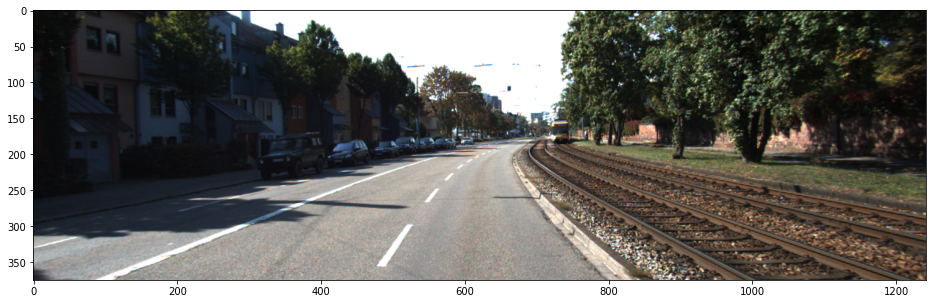

In [6]:
plt.figure(figsize=(16,9))
plt.imshow(cam2_gen)

In [7]:
xml_path = "data/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml"
velo_to_cam_path = "data/2011_09_26/calib_velo_to_cam.txt"

In [8]:
tracklets = parse_tracklet_xml.parseXML(xml_path)

Parsing tracklet file: data/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml
File contains 15 tracklets
Loaded 15 tracklets.


In [9]:
print(tracklets[0])

[Tracklet over 14 frames for Car]


In [10]:
def cart2homogen(points3D):
    n = points3D.shape[0]
    homogen_points3D = np.hstack((points3D, np.ones((n, 1))))
    return homogen_points3D

In [11]:
def load_Rt_velo_to_cam(path: str):
    lines = []
    with open(path, 'r') as fp: 
        for line in fp.readlines():
            lines.append(line)
    lines = lines[1:3]
    # rotation matrix
    velo_to_cam_rotations = lines[0].split(' ')[1:]
    velo_to_cam_rotations = np.array([float(el.strip()) 
                                      for el in velo_to_cam_rotations]).reshape((3,3))
    # translation 
    velo_to_cam_translation = lines[1].split(' ')[1:]
    velo_to_cam_translation = np.array([float(el.strip()) 
                                        for el in velo_to_cam_translation]).reshape((3,1))
    Rt_velo_to_cam = np.hstack((velo_to_cam_rotations, velo_to_cam_translation))
    Rt_velo_to_cam = np.vstack((Rt_velo_to_cam, np.array([0, 0, 0, 1])))
    
    return Rt_velo_to_cam

In [12]:
def tracklets_velo2cam_2d(tracklets, dataset, velo_to_cam_path: str, n_frames: int, camera_id=2):
    tracklets_2d_boxes = {}
    tracklets_2d_boxes_types = {}
    
    for i in range(n_frames):
        tracklets_2d_boxes[i] = []
        tracklets_2d_boxes_types[i] = []
        
    R_rect_00 = dataset.calib.R_rect_00
    
    if camera_id == 0:
        P_rect = dataset.calib.P_rect_00
    elif camera_id == 1:
        P_rect = dataset.calib.P_rect_10
    elif camera_id == 2:
        P_rect = dataset.calib.P_rect_20
    elif camera_id == 3:
        P_rect = dataset.calib.P_rect_30
        
    Rt_velo_to_cam = load_Rt_velo_to_cam(velo_to_cam_path)
    
    for i, tracklet in enumerate(tracklets):
        
        h, w, l = tracklet.size
        # in velodyne coordinates around zero point and without orientation yet
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        
        for (translation, rotation, state, occlusion, 
             truncation, amtOcclusion, amtBorders, 
             absoluteFrameNumber) in tracklet:
            
            if truncation not in [0, 1]: # 0 -> in image, 1 -> truncated
                continue 
                
            yaw = rotation[2]
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            # rotation around z-axis 
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            # transform to homogenuous coordinates
            cornerPosInVeloHomo = cart2homogen(cornerPosInVelo.T)
            
            cornerPosInCameraHomo = Rt_velo_to_cam @ cornerPosInVeloHomo.T
            cornerPosInCameraHomo = R_rect_00 @ cornerPosInCameraHomo
            cornerPosInCameraHomo = P_rect @ cornerPosInCameraHomo
            
            cornerPosInCameraHomo = cornerPosInCameraHomo.T
            # transform to pixel coordinates
            cornerPosInCameraHomo[:,0] /= cornerPosInCameraHomo[:,2]
            cornerPosInCameraHomo[:,1] /= cornerPosInCameraHomo[:,2]
            cornerPosInCamera = cornerPosInCameraHomo[:,:2]
            
            tracklets_2d_boxes[absoluteFrameNumber] = tracklets_2d_boxes[absoluteFrameNumber] + [cornerPosInCamera]
            tracklets_2d_boxes_types[absoluteFrameNumber] = tracklets_2d_boxes_types[absoluteFrameNumber] + [tracklet.objectType]
    
    
    return tracklets_2d_boxes, tracklets_2d_boxes_types

In [13]:
tracklets_2d_boxes, tracklets_2d_boxes_types = tracklets_velo2cam_2d(tracklets, 
                                                                     dataset, 
                                                                     velo_to_cam_path, 
                                                                     n_frames=len(list(dataset.cam2)), 
                                                                     camera_id=2)

In [14]:
len(tracklets_2d_boxes)

108

In [15]:
len(tracklets_2d_boxes_types)

108

In [16]:
cam2_gen = np.asarray(dataset.get_cam2(0))
boxes2d = tracklets_2d_boxes.get(0)
cam2_gen.shape 

(375, 1242, 3)

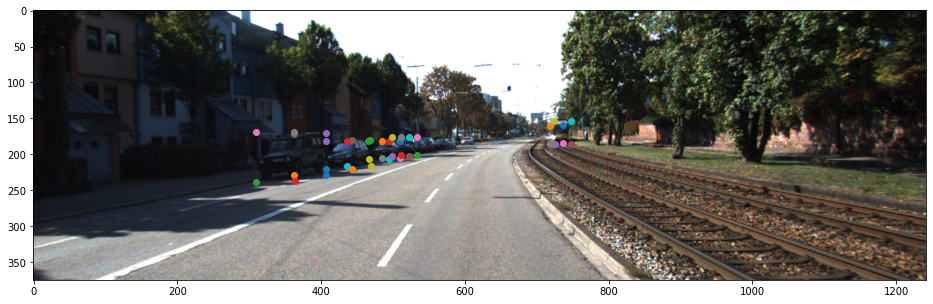

In [17]:
plt.figure(figsize=(16,9))
plt.imshow(cam2_gen)
for box in boxes2d:
    for point in box:
        plt.scatter(point[0], point[1])

In [18]:
print(boxes2d[0])

[[407.4699 228.4183]
 [362.681  228.7682]
 [309.9757 238.0073]
 [363.1201 237.6204]
 [407.0288 170.6178]
 [362.2785 171.1225]
 [309.5492 169.4269]
 [362.6393 168.8207]]


In [19]:
# 0 -> right, back, down
# 1 -> left, back, down
# 2 -> left, front, down
# 3 -> right, front, down 
# 4 -> right, back, up
# 5 -> left, back, up
# 6 -> left, front, up
# 7 -> right, front, up 
connections = [[0, 1], [1, 2], [2, 3], [3, 0], 
               [4, 5], [5, 6], [6, 7], [7, 4], 
               [0, 4], [1, 5], [2, 6], [3, 7], 
               [0, 5], [1, 4]]

In [20]:
def draw_3d_boxes_img(dataset, frame_id, tracklets_2d_boxes, connections, color=(128, 255, 128), thickness=1):
    
    cam2_gen = np.asarray(dataset.get_cam2(frame_id))
    boxes = tracklets_2d_boxes.get(frame_id)
    
    for box in boxes:
        for connection in connections:
            start = box[connection[0]]
            end = box[connection[1]]
            start = (int(start[0]), int(start[1]))
            end = (int(end[0]), int(end[1]))
            cam2_gen = cv2.line(cam2_gen, start, end, color, thickness)
    
    return cam2_gen

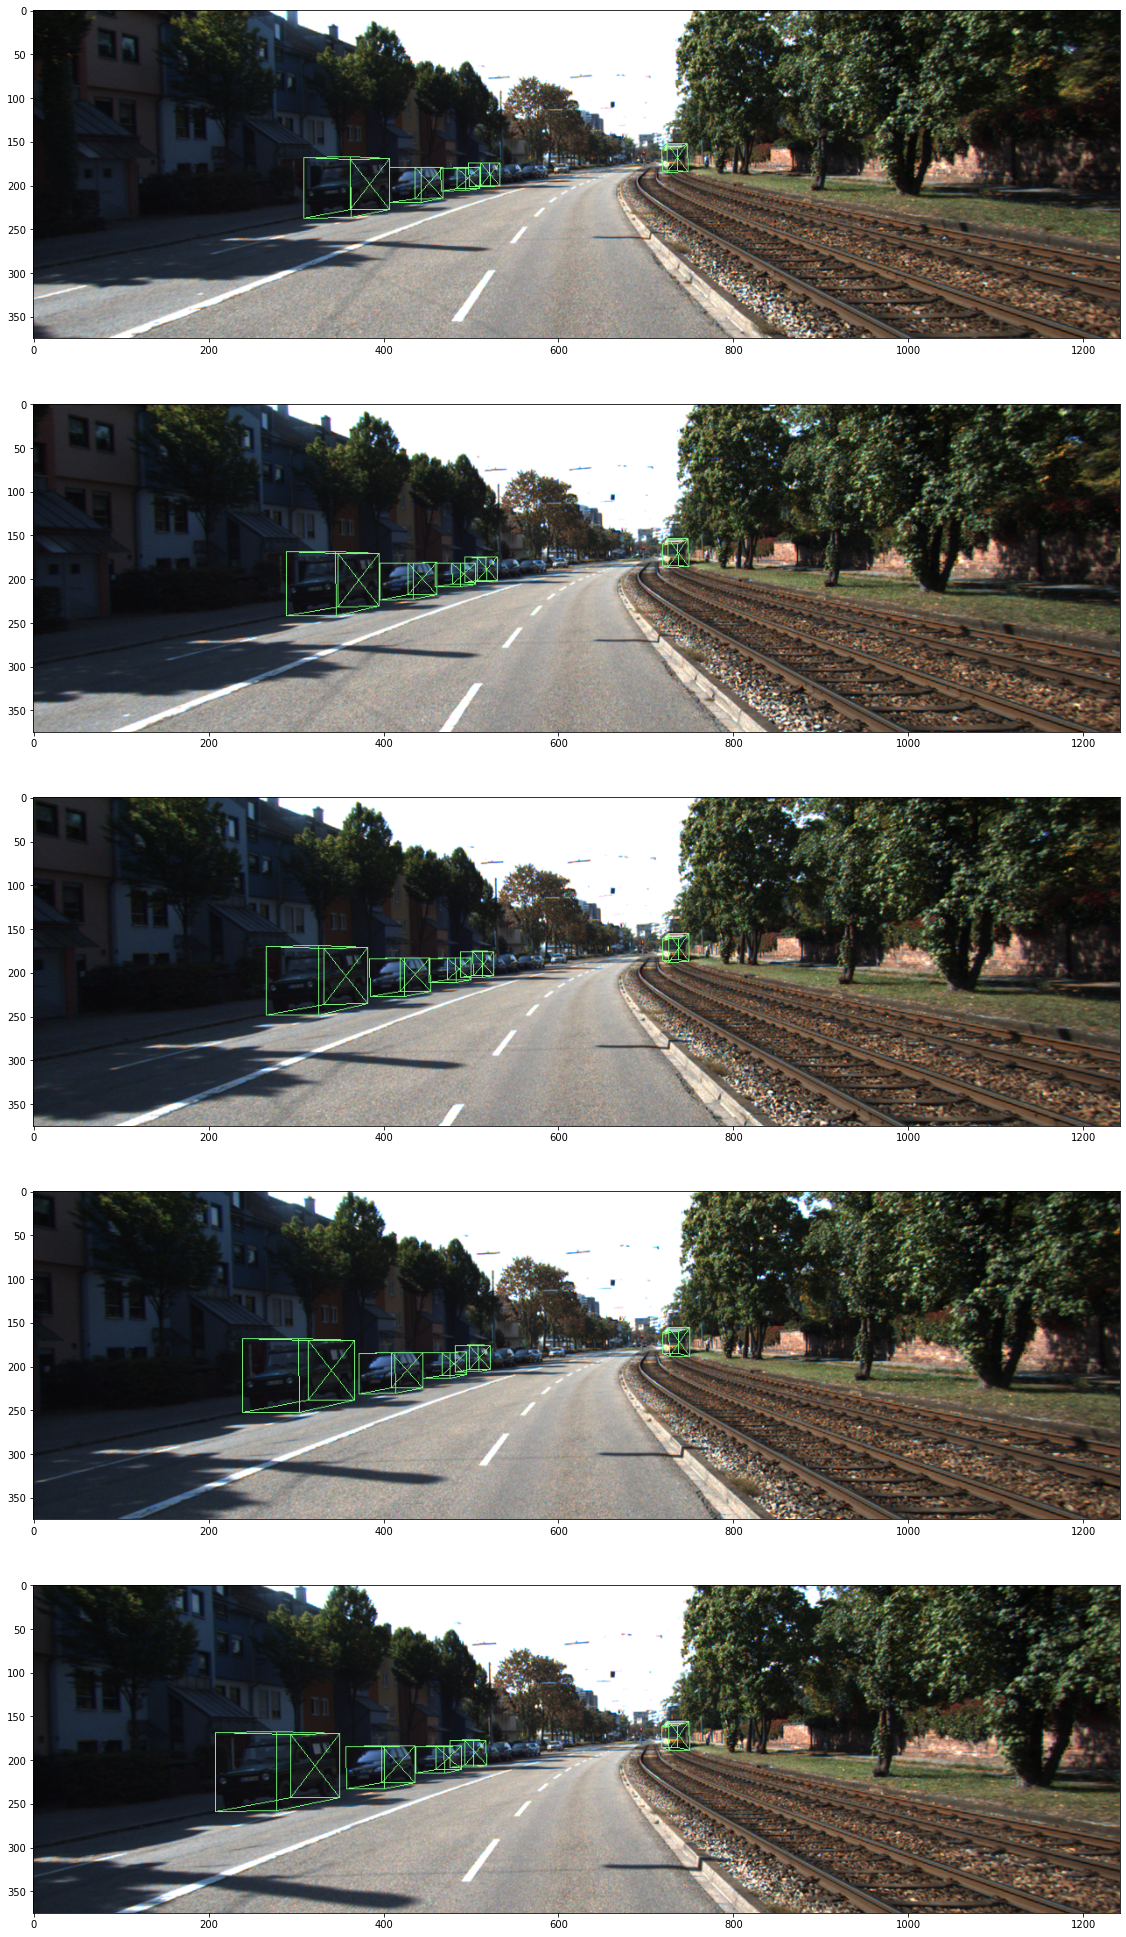

In [21]:
fig = plt.figure(figsize=(20,5*7))
columns = 1
rows = 5
ax = []
imgs = [draw_3d_boxes_img(dataset, i, tracklets_2d_boxes, connections) for i in range(columns * rows)]

for i in range(columns * rows):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    plt.imshow( imgs[i] )

plt.show()

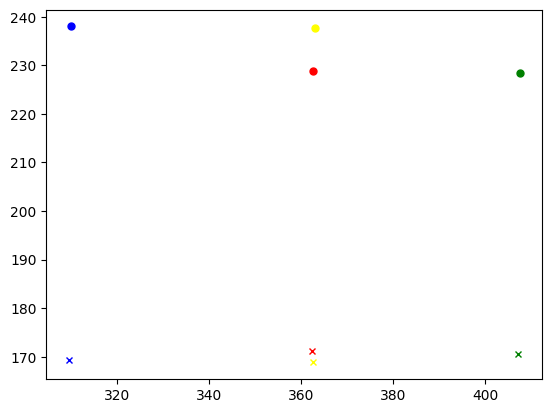

In [91]:
plt.figure()
# down 
# right back
plt.plot([boxes2d[0][0,0]], [boxes2d[0][0,1]], marker="o", markersize=5, markeredgecolor="green", markerfacecolor="green")

plt.plot([boxes2d[0][1,0]], [boxes2d[0][1,1]], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")

plt.plot([boxes2d[0][2,0]], [boxes2d[0][2,1]], marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="blue")

plt.plot([boxes2d[0][3,0]], [boxes2d[0][3,1]], marker="o", markersize=5, markeredgecolor="yellow", markerfacecolor="yellow")

# up
# right back
plt.plot([boxes2d[0][4,0]], [boxes2d[0][4,1]], marker="x", markersize=5, markeredgecolor="green", markerfacecolor="green")

plt.plot([boxes2d[0][5,0]], [boxes2d[0][5,1]], marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")

plt.plot([boxes2d[0][6,0]], [boxes2d[0][6,1]], marker="x", markersize=5, markeredgecolor="blue", markerfacecolor="blue")

plt.plot([boxes2d[0][7,0]], [boxes2d[0][7,1]], marker="x", markersize=5, markeredgecolor="yellow", markerfacecolor="yellow")

plt.show()

In [32]:
boxes2d[0][0,0]

407.46986105906586

In [ ]:
h, w, l = tracklets[0].size
print("Height: {}".format(h))
print("Width: {}".format(w))
print("Length: {}".format(l))

In [ ]:
translation = tracklets[0].trans[0]
translation

In [ ]:
yaw = tracklets[0].rots[0][2]
yaw

In [ ]:
# rotation around the y axis 
rotation_matrix = np.array([
    [np.cos(yaw), 0, np.sin(yaw)], 
    [0, 1, 0], 
    [-np.sin(yaw), 0, -np.cos(yaw)]
])

In [ ]:
trackletBox = np.array([
    [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
    [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
    [0.0, 0.0, 0.0, 0.0, h, h, h, h]
])

In [ ]:
x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2]
y_corners = [0,0,0,0,-h,-h,-h,-h]
z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2]

In [ ]:
# rotate the corner coordinates
tracklet_box = np.vstack([x_corners, y_corners, z_corners])
tracklet_box

In [ ]:
help(dataset.calib)

In [ ]:
R_rect_00 = dataset.calib.R_rect_00
R_rect_00

In [ ]:
P_rect_20 = dataset.calib.P_rect_20
P_rect_20

In [ ]:
velo_to_cam = "/home/johann/dev/kitti-data-exploration/data/2011_09_26/calib_velo_to_cam.txt"
lines = []
with open(velo_to_cam, 'r') as fp: 
    for line in fp.readlines():
        lines.append(line)

lines

In [ ]:
lines = lines[1:3]
lines

In [ ]:
velo_to_cam_rotations = lines[0].split(' ')[1:]
velo_to_cam_rotations = np.array([float(el.strip()) for el in velo_to_cam_rotations]).reshape((3,3))
velo_to_cam_rotations

In [ ]:
velo_to_cam_translation = lines[1].split(' ')[1:]
velo_to_cam_translation = np.array([float(el.strip()) for el in velo_to_cam_translation]).reshape((3,1))
velo_to_cam_translation

In [ ]:
Rt_velo_to_cam = np.hstack((velo_to_cam_rotations, velo_to_cam_translation))
Rt_velo_to_cam

In [ ]:
Rt_velo_to_cam = np.vstack((Rt_velo_to_cam, np.array([0, 0, 0, 1])))
Rt_velo_to_cam

In [ ]:
trackletBox

In [ ]:
rotMat = np.array([
    [np.cos(yaw), -np.sin(yaw), 0.0],
    [np.sin(yaw), np.cos(yaw), 0.0],
    [0.0, 0.0, 1.0]
])

In [ ]:
cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T

In [ ]:
cornerPosInVelo.T

In [ ]:
cornerPosInVeloHomo = cart2homogen(cornerPosInVelo.T)
cornerPosInVeloHomo

In [ ]:
test = Rt_velo_to_cam @ cornerPosInVeloHomo.T
test.shape

In [ ]:
test.T

In [ ]:
test = R_rect_00 @ test
test.shape 

In [ ]:
test.T

In [ ]:
test = P_rect_20 @ test
test.shape 

In [ ]:
test.T

In [ ]:
test = test.T
test[:,0] /= test[:,2]
test[:,1] /= test[:,2]
test = test[:,:2]

In [ ]:
test[:,0] /= test[:,2]
test[:,1] /= test[:,2]
test

In [ ]:
test = test[:,:2]
test

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(cam2_gen)
plt.scatter(x=test[:,0], y=test[:,1])

In [ ]:
tracklet_box_homo = cart2homogen(tracklet_box.T)
tracklet_box_homo

In [ ]:
# In order to transform a homogeneous point X = [x y z 1]' from the velodyne
# coordinate system to a homogeneous point Y = [u v 1]' on image plane of
# camera xx, the following transformation has to be applied:
#    
# Y = P_rect_xx * R_rect_00 * (R|T)_velo_to_cam * X

In [ ]:
# tracklet_box_homo_cam = P_rect_00 @ R_rect_00 @ Rt_velo_to_cam @ tracklet_box_homo

In [ ]:
tracklet_box_homo.shape

In [ ]:
Rt_velo_to_cam.shape

In [ ]:
test = Rt_velo_to_cam @ tracklet_box_homo.T
test.shape

In [ ]:
test.T

In [ ]:
test = R_rect_00 @ test
test.shape 

In [ ]:
test.T

In [ ]:
test = P_rect_20 @ test
test.shape 

In [ ]:
test = test.T
test

In [ ]:
test[:,0] /= test[:,2]
test[:,1] /= test[:,2]
test

In [ ]:
test = test[:, :2]
test

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(cam2_gen)
plt.scatter(x=test[:,0], y=test[:,1])

In [ ]:
Rt_velo_to_cam.shape

In [ ]:
P_rect_00.shape

In [ ]:
R_rect_00.shape

In [ ]:
tracklet_box_homo.shape

In [ ]:
corners_3d_cam2 = np.dot(rotation_matrix, tracklet_box)
corners_3d_cam2

In [ ]:
corners_3d_cam2.shape

In [ ]:
translation = np.vstack([x, y, z])
translation

In [ ]:
translations = np.tile(translation.T, (8,1))
translations.shape

In [ ]:
corners_3d_cam2 = corners_3d_cam2.T
corners_3d_cam2

In [ ]:
corners_3d_cam2 += translations
corners_3d_cam2

In [ ]:
# 3d points in rectified camera coordinates
corners_3d_cam2

In [ ]:
def cart2homogen(points3D):
    n = points3D.shape[0]
    homogen_points3D = np.hstack((points3D, np.ones((n, 1))))
    return homogen_points3D

In [ ]:
corners_3d_cam2_hom = cart2homogen(corners_3d_cam2)
corners_3d_cam2_hom.shape

In [ ]:
corners_3d_cam2_hom

In [ ]:
help(dataset.calib)

In [ ]:
T_cam2_velo = dataset.calib.T_cam2_velo
T_cam2_velo.shape

In [ ]:
T_cam2_velo

In [ ]:
test = np.dot(corners_3d_cam2_hom, T_cam2_velo)
test.shape

In [ ]:
test

In [ ]:
# projection matrix from rect camera 3d coordinates to image 2d coordinates
projection_matrix = dataset.calib.P_rect_20.T
projection_matrix.shape

In [ ]:
projection_matrix

In [ ]:
points2D = np.dot(test, projection_matrix)
points2D.shape

In [ ]:
points2D

In [ ]:
points2D[:,0] /= points2D[:,2]
points2D

In [ ]:
points2D[:,1] /= points2D[:,2]
points2D

In [ ]:
points2D = points2D[:, :2]
points2D

In [ ]:

point_cam0 = dataset.calib.T_cam0_velo.dot(point_velo)

In [ ]:
dataset.calib

In [ ]:
tracklet_rects, tracklet_types = load_tracklets_for_frames(
    len(list(dataset.velo)), 
    'data/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(date, date, drive), 
)

In [ ]:
tracklet_rects[0]